In [1]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

/home/wyz5rge/.local/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /scratch/wyz5rge/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Set up parameters, create isochrone grid

In [2]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F182M']
filters = ['m_jwst_F115W', 'm_jwst_F182M']
iso_dir = 'isochrones/'
metallicity = 0

In [3]:
# read nbody data
path_to_data = '../../../../../../storage/jfarias/Data/Orion/massive_clusters/M3000new/sigma0p1/fiducial/sfe_ff003/00/'
snapshot = Reader.read_snapshot(path_to_data, time = 20)

# convert snapshot values from nbody units to astrophysical, extract masses
snapshot.to_physical()

# read ages for simulated stars
cluster_table = converter.to_spicea_table(snapshot)

print(cluster_table)

        mass         isMultiple       compMass            systemMass              e                log_a               age        
-------------------- ---------- -------------------- ------------------- ------------------- ------------------ ------------------
  12.818908070209863        0.0                   []  12.818908070209863                 nan                nan  19.28537582919208
  4.9549285763343764        0.0                   []  4.9549285763343764                 nan                nan  19.28537582919208
   8.067212571515112        0.0                   []   8.067212571515112                 nan                nan 17.289245730887043
   6.946275907178013        0.0                   []   6.946275907178013                 nan                nan 18.475896770218082
                 ...        ...                  ...                 ...                 ...                ...                ...
  0.9489406533298774        1.0 [0.8626064417911955]  1.8115470951210728  0.5844278

In [4]:
masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6

# convert log ages from log(Myr) to log(yr)
log_ages = np.log10(level_ages)

# print(log_ages)
print("Min log age = " + str(min(log_ages)))
print("Max log age = " + str(max(log_ages)))

# print(level_ages)
print("Min level age = " + str(min(level_ages)))
print("Max level age = " + str(max(level_ages)))

Min log age = 7.138402542266087
Max log age = 7.3011106695566514
Min level age = 13753161.482015437
Max level age = 20003715.51513672


In [5]:
# find index of first binary, create array of companion masses
first_binary = 0
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        first_binary = i
        break
print(first_binary)

compMasses = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses.append(cluster_table['compMass'][i][0])
print(compMasses)

1641
[0.3241624348251086, 0.05095402070602342, 0.06758268036155689, 0.2634619140232143, 3.0305143670780916, 0.019100480058271217, 0.013328533048159051, 0.12267811531436108, 0.16160452370753137, 0.01442445815642728, 0.09685313419544767, 0.02206295254684064, 0.026062091840581544, 0.23206340246858242, 0.010659884204343559, 0.09138690863698644, 0.021026970199695943, 0.07079943158521453, 0.0581860983356197, 0.015522067753595834, 0.11540233656694762, 0.015276826165350291, 0.03731041177184101, 0.25969868292158427, 0.20332028766917049, 0.032323356109109164, 0.18928016428521058, 0.09898339956998825, 0.11899845630244968, 0.21501117944717407, 0.06470821052789688, 0.016764014959335327, 0.04054572198307689, 0.03195300950979017, 0.031136754900217056, 0.09390845096561119, 0.1048092469573021, 0.03370909553992068, 0.13829360753641778, 0.4990076216989321, 0.20981368313804674, 0.12287444910273947, 0.016603971205854686, 0.04813299634079317, 0.23601408835929072, 1.8674397463219425, 0.04728714545608921, 0.0

In [6]:
start = (min(level_ages) // 0.5e6) * 0.5e6
end = (max(level_ages) // 0.5e6) * 0.5e6 + 2 * 0.5e6
increment = 0.5e6  # 500,000

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

print(log_age_arr)
print(level_age_arr)

[7.13033377 7.14612804 7.161368   7.17609126 7.1903317  7.20411998
 7.21748394 7.23044892 7.24303805 7.25527251 7.26717173 7.2787536
 7.29003461 7.30103    7.31175386]
[13500000. 14000000. 14500000. 15000000. 15500000. 16000000. 16500000.
 17000000. 17500000. 18000000. 18500000. 19000000. 19500000. 20000000.
 20500000.]


In [7]:
# create isochrone grid - if this is the first time, then this is going to take an hour lmfao
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

isochrone generation done


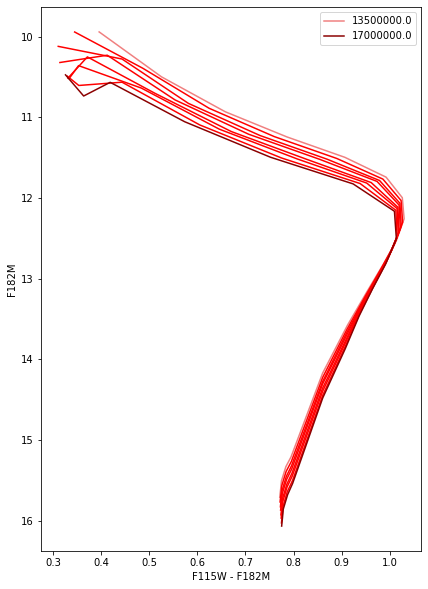

In [8]:
# identify array indeces, create array for labels and colors
idx_arr = range(0, len(log_age_arr))
if len(idx_arr) > 3:
    idx_arr = idx_arr[::2]

# Plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

In [9]:
import sys
sys.path.append('/scratch/wyz5rge/synthetic-hr/12-18')
import interpolatorExp as interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    # print(str(i) + " " + str(level_ages_myr[i]) + " " + str(masses[i]))
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
# convert luminosity values to solar luminosities
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun

for i in range(len(stars)):
    if stars[i] is None:
        continue
    stars[i][0] = stars[i][0] * watts_to_lsun
    
for i in range(len(stars)):
    print(stars[i])

Desired mass 12.818908070209863 is outside the range of the isochrone.
Desired mass 12.818908070209863 is outside the range of the isochrone.
Desired mass 4.9549285763343764 is outside the range of the isochrone.
Desired mass 4.9549285763343764 is outside the range of the isochrone.
Desired mass 8.067212571515112 is outside the range of the isochrone.
Desired mass 8.067212571515112 is outside the range of the isochrone.
Desired mass 6.946275907178013 is outside the range of the isochrone.
Desired mass 6.946275907178013 is outside the range of the isochrone.
Desired mass 14.39111404199985 is outside the range of the isochrone.
Desired mass 14.39111404199985 is outside the range of the isochrone.
Desired mass 5.054289841790398 is outside the range of the isochrone.
Desired mass 5.054289841790398 is outside the range of the isochrone.
Desired mass 0.01651090504541876 is outside the range of the isochrone.
Desired mass 0.01651090504541876 is outside the range of the isochrone.
Desired mass

Desired mass 0.040046613519918395 is outside the range of the isochrone.
Desired mass 0.040046613519918395 is outside the range of the isochrone.
Desired mass 0.022733663112398196 is outside the range of the isochrone.
Desired mass 0.022733663112398196 is outside the range of the isochrone.
Desired mass 0.01564574562779487 is outside the range of the isochrone.
Desired mass 0.01564574562779487 is outside the range of the isochrone.
Desired mass 0.049458203157467115 is outside the range of the isochrone.
Desired mass 0.049458203157467115 is outside the range of the isochrone.
Desired mass 0.017323976970234505 is outside the range of the isochrone.
Desired mass 0.017323976970234505 is outside the range of the isochrone.
Desired mass 0.012045389071983475 is outside the range of the isochrone.
Desired mass 0.012045389071983475 is outside the range of the isochrone.
Desired mass 0.04657670373089686 is outside the range of the isochrone.
Desired mass 0.04657670373089686 is outside the range 

Desired mass 0.018630477772322275 is outside the range of the isochrone.
Desired mass 0.018630477772322275 is outside the range of the isochrone.
Desired mass 0.03536162314144712 is outside the range of the isochrone.
Desired mass 0.03536162314144712 is outside the range of the isochrone.
Desired mass 0.04193275692590212 is outside the range of the isochrone.
Desired mass 0.04193275692590212 is outside the range of the isochrone.
Desired mass 0.06255857428587634 is outside the range of the isochrone.
Desired mass 0.06255857428587634 is outside the range of the isochrone.
Desired mass 0.017946948048245103 is outside the range of the isochrone.
Desired mass 0.017946948048245103 is outside the range of the isochrone.
Desired mass 3.3337101801694886 is outside the range of the isochrone.
Desired mass 3.3337101801694886 is outside the range of the isochrone.
Desired mass 0.017723748815987882 is outside the range of the isochrone.
Desired mass 0.017723748815987882 is outside the range of the

Desired mass 0.02018790355198907 is outside the range of the isochrone.
Desired mass 0.02018790355198907 is outside the range of the isochrone.
Desired mass 0.06672175851991183 is outside the range of the isochrone.
Desired mass 0.06672175851991183 is outside the range of the isochrone.
Desired mass 0.01971857061502275 is outside the range of the isochrone.
Desired mass 0.01971857061502275 is outside the range of the isochrone.
Desired mass 0.062145686448203064 is outside the range of the isochrone.
Desired mass 0.062145686448203064 is outside the range of the isochrone.
Desired mass 0.022432429272263788 is outside the range of the isochrone.
Desired mass 0.022432429272263788 is outside the range of the isochrone.
Desired mass 0.05599719589526174 is outside the range of the isochrone.
Desired mass 0.05599719589526174 is outside the range of the isochrone.
Desired mass 0.01996599778541854 is outside the range of the isochrone.
Desired mass 0.01996599778541854 is outside the range of the

Desired mass 0.04160037301822054 is outside the range of the isochrone.
Desired mass 0.04160037301822054 is outside the range of the isochrone.
Desired mass 0.015625005408609175 is outside the range of the isochrone.
Desired mass 0.015625005408609175 is outside the range of the isochrone.
Desired mass 0.05158849369460897 is outside the range of the isochrone.
Desired mass 0.05158849369460897 is outside the range of the isochrone.
Desired mass 0.0185711763775285 is outside the range of the isochrone.
Desired mass 0.0185711763775285 is outside the range of the isochrone.
Desired mass 0.055104932781414644 is outside the range of the isochrone.
Desired mass 0.055104932781414644 is outside the range of the isochrone.
Desired mass 14.116537012769738 is outside the range of the isochrone.
Desired mass 14.116537012769738 is outside the range of the isochrone.
Desired mass 4.22139362636025 is outside the range of the isochrone.
Desired mass 4.22139362636025 is outside the range of the isochrone

Desired mass 0.03361565168649726 is outside the range of the isochrone.
Desired mass 0.03361565168649726 is outside the range of the isochrone.
Desired mass 0.05144971324160257 is outside the range of the isochrone.
Desired mass 0.05144971324160257 is outside the range of the isochrone.
Desired mass 2.2333158943506604 is outside the range of the isochrone.
Desired mass 2.2333158943506604 is outside the range of the isochrone.
Desired mass 0.017453425515848085 is outside the range of the isochrone.
Desired mass 0.017453425515848085 is outside the range of the isochrone.
Desired mass 0.06330529087012302 is outside the range of the isochrone.
Desired mass 0.06330529087012302 is outside the range of the isochrone.
Desired mass 0.03246975074835317 is outside the range of the isochrone.
Desired mass 0.03246975074835317 is outside the range of the isochrone.
Desired mass 0.030785680135191812 is outside the range of the isochrone.
Desired mass 0.030785680135191812 is outside the range of the i

Desired mass 0.055250130206816406 is outside the range of the isochrone.
Desired mass 0.055250130206816406 is outside the range of the isochrone.
Desired mass 0.06633097974120507 is outside the range of the isochrone.
Desired mass 0.06633097974120507 is outside the range of the isochrone.
Desired mass 0.050938569562620765 is outside the range of the isochrone.
Desired mass 0.050938569562620765 is outside the range of the isochrone.
Desired mass 0.04770933765740783 is outside the range of the isochrone.
Desired mass 0.04770933765740783 is outside the range of the isochrone.
Desired mass 0.0290392754981663 is outside the range of the isochrone.
Desired mass 0.0290392754981663 is outside the range of the isochrone.
Desired mass 0.03620472574093321 is outside the range of the isochrone.
Desired mass 0.03620472574093321 is outside the range of the isochrone.
Desired mass 0.05103786710980501 is outside the range of the isochrone.
Desired mass 0.05103786710980501 is outside the range of the i

Desired mass 0.012552560589414953 is outside the range of the isochrone.
Desired mass 0.012552560589414953 is outside the range of the isochrone.
Desired mass 0.045673212292575205 is outside the range of the isochrone.
Desired mass 0.045673212292575205 is outside the range of the isochrone.
Desired mass 1.6927607346794256 is outside the range of the isochrone.
Desired mass 1.6927607346794256 is outside the range of the isochrone.
Desired mass 0.03774122925952733 is outside the range of the isochrone.
Desired mass 0.03774122925952733 is outside the range of the isochrone.
Desired mass 0.06546605108741162 is outside the range of the isochrone.
Desired mass 0.06546605108741162 is outside the range of the isochrone.
Desired mass 0.044183501192582735 is outside the range of the isochrone.
Desired mass 0.044183501192582735 is outside the range of the isochrone.
Desired mass 0.026852634454456594 is outside the range of the isochrone.
Desired mass 0.026852634454456594 is outside the range of t

Desired mass 1.7666650022953063 is outside the range of the isochrone.
Desired mass 1.7666650022953063 is outside the range of the isochrone.
Desired mass 0.02101850835201073 is outside the range of the isochrone.
Desired mass 0.02101850835201073 is outside the range of the isochrone.
Desired mass 0.011978011431240223 is outside the range of the isochrone.
Desired mass 0.011978011431240223 is outside the range of the isochrone.
Desired mass 0.04279653748968966 is outside the range of the isochrone.
Desired mass 0.04279653748968966 is outside the range of the isochrone.
Desired mass 0.040438779254154275 is outside the range of the isochrone.
Desired mass 0.040438779254154275 is outside the range of the isochrone.
Desired mass 0.019761067065098697 is outside the range of the isochrone.
Desired mass 0.019761067065098697 is outside the range of the isochrone.
Desired mass 0.029425820012839145 is outside the range of the isochrone.
Desired mass 0.029425820012839145 is outside the range of t

Desired mass 1.6426758570167126 is outside the range of the isochrone.
Desired mass 1.6426758570167126 is outside the range of the isochrone.
Desired mass 0.03828270944181736 is outside the range of the isochrone.
Desired mass 0.03828270944181736 is outside the range of the isochrone.
Desired mass 0.05590396696611461 is outside the range of the isochrone.
Desired mass 0.05590396696611461 is outside the range of the isochrone.
Desired mass 0.01472045363260129 is outside the range of the isochrone.
Desired mass 0.01472045363260129 is outside the range of the isochrone.
Desired mass 0.05443995576567673 is outside the range of the isochrone.
Desired mass 0.05443995576567673 is outside the range of the isochrone.
Desired mass 0.06523746220395678 is outside the range of the isochrone.
Desired mass 0.06523746220395678 is outside the range of the isochrone.
Desired mass 0.06549402130018174 is outside the range of the isochrone.
Desired mass 0.06549402130018174 is outside the range of the isoch

Desired mass 0.06898265341824697 is outside the range of the isochrone.
Desired mass 0.06898265341824697 is outside the range of the isochrone.
Desired mass 0.02756333464426778 is outside the range of the isochrone.
Desired mass 0.02756333464426778 is outside the range of the isochrone.
Desired mass 0.06525115788663534 is outside the range of the isochrone.
Desired mass 0.06525115788663534 is outside the range of the isochrone.
Desired mass 0.029098016027331076 is outside the range of the isochrone.
Desired mass 0.029098016027331076 is outside the range of the isochrone.
Desired mass 0.0277175575935366 is outside the range of the isochrone.
Desired mass 0.0277175575935366 is outside the range of the isochrone.
Desired mass 0.03958210487442333 is outside the range of the isochrone.
Desired mass 0.03958210487442333 is outside the range of the isochrone.
Desired mass 0.03228703089206875 is outside the range of the isochrone.
Desired mass 0.03228703089206875 is outside the range of the iso

[0.2170322967062067, 4107.938, 4.418, 13.103, 12.093]
[0.19826188899742733, 4054.66, 4.421, 13.186, 12.17]
[0.027355541475458777, 3294.291, 4.387, 15.092, 14.218]
None
[0.009852801080254867, 3064.857, 4.364, 16.109, 15.309]
None
None
None
[0.020914609451085267, 3209.13, 4.355, 15.39, 14.545]
None
[0.5190982762979158, 4660.703, 4.364, 12.29, 11.461]
None
None
[0.0702463569399613, 3533.622, 4.372, 14.143, 13.188]
[0.005895936497432183, 2949.189, 4.352, 16.604, 15.831]
[0.0059410445519096754, 2951.037, 4.352, 16.597, 15.823]
[0.0133002969901374, 3124.888, 4.394, 15.901, 15.083]
[0.03694997504006123, 3341.276, 4.353, 14.78, 13.885]
None
[0.019977036707896162, 3196.719, 4.356, 15.451, 14.61]
None
None
None
[0.033901565428982094, 3320.135, 4.353, 14.873, 13.987]
[0.10393080872074535, 3689.042, 4.388, 13.776, 12.784]
[0.010663059213325133, 3075.195, 4.363, 16.055, 15.253]
[0.020494951100688243, 3203.279, 4.355, 15.418, 14.574]
None
[0.016781783613698087, 3154.894, 4.358, 15.659, 14.83]
None
[

None
[0.04183336409350516, 3396.7, 4.384, 14.644, 13.732]
[0.046312208232292845, 3422.938, 4.387, 14.556, 13.636]
[0.06755977904482759, 3541.267, 4.4, 14.189, 13.236]
None
None
None
[0.028764700748928687, 3302.541, 4.383, 15.044, 14.167]
[0.013282346319441382, 3123.519, 4.392, 15.901, 15.083]
[0.005998961283224338, 2970.194, 4.384, 16.592, 15.816]
None
[0.0643927588890887, 3524.672, 4.397, 14.232, 13.284]
None
[0.12031668730786037, 3778.389, 4.418, 13.649, 12.646]
[0.008815205756829547, 3060.116, 4.395, 16.21, 15.412]
None
None
None
None
None
[0.32038261995162287, 4365.116, 4.404, 12.738, 11.79]
[0.037605053544326986, 3366.666, 4.381, 14.758, 13.856]
None
None
[0.005451694130557594, 2946.669, 4.382, 16.69, 15.915]
None
[0.02820750374971418, 3296.974, 4.381, 15.061, 14.186]
[0.023083384122623098, 3259.228, 4.381, 15.227, 14.366]
None
[0.034829042608825446, 3345.525, 4.38, 14.848, 13.954]
[0.005741511042840732, 2958.852, 4.382, 16.637, 15.861]
None
None
None
[0.04279046858706368, 3400.2,

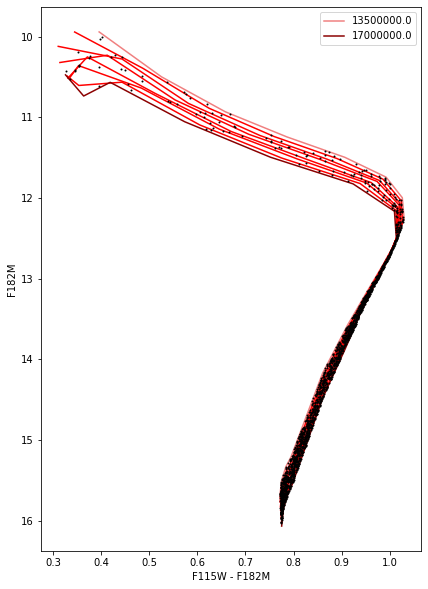

In [10]:
fig, axes = py.subplots(figsize=(15, 10))

# plot CMD
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

for i in range(len(stars)):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')